# FIKH Model: Creep Response

## Learning Objectives

1. Fit FIKH to **creep (step stress)** experimental data
2. Understand **delayed yielding** and viscosity bifurcation with fractional memory
3. Analyze how **alpha_structure** affects creep acceleration
4. Explore the transition from solid-like to liquid-like behavior
5. Compare fractional vs classical creep dynamics

## Prerequisites

- NB01: FIKH Flow Curve (concepts)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_ml_ikh_creep,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    plot_alpha_sweep,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Fractional Creep

Creep response under constant applied stress reveals **delayed yielding** and **viscosity bifurcation**.

### Creep Regimes

1. **Elastic response** ($t \ll \tau$): $\gamma \approx \sigma/G$
2. **Delayed yielding**: Strain accelerates as structure breaks down
3. **Steady flow** ($t \gg \tau$): $\dot{\gamma} \to \dot{\gamma}_{ss}$

### Alpha Effect on Creep

- **Lower alpha**: Slower approach to yielding, stretched acceleration
- **Higher alpha**: Sharper yield transition (classical behavior)

## 3. Load Data

In [3]:
# Load creep data from ML-IKH Excel
STRESS_PAIR = 0  # First stress jump (3 Pa → 5 Pa)
time_data, gamma_dot_data, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=STRESS_PAIR)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Shear rate range: [{gamma_dot_data.min():.4g}, {gamma_dot_data.max():.4g}] 1/s")
print(f"Stress jump: {sigma_init} Pa → {sigma_final} Pa")

Data points: 70
Time range: [0.0098, 295.66] s
Shear rate range: [3.222, 6.264] 1/s
Stress jump: 3.0 Pa → 5.0 Pa


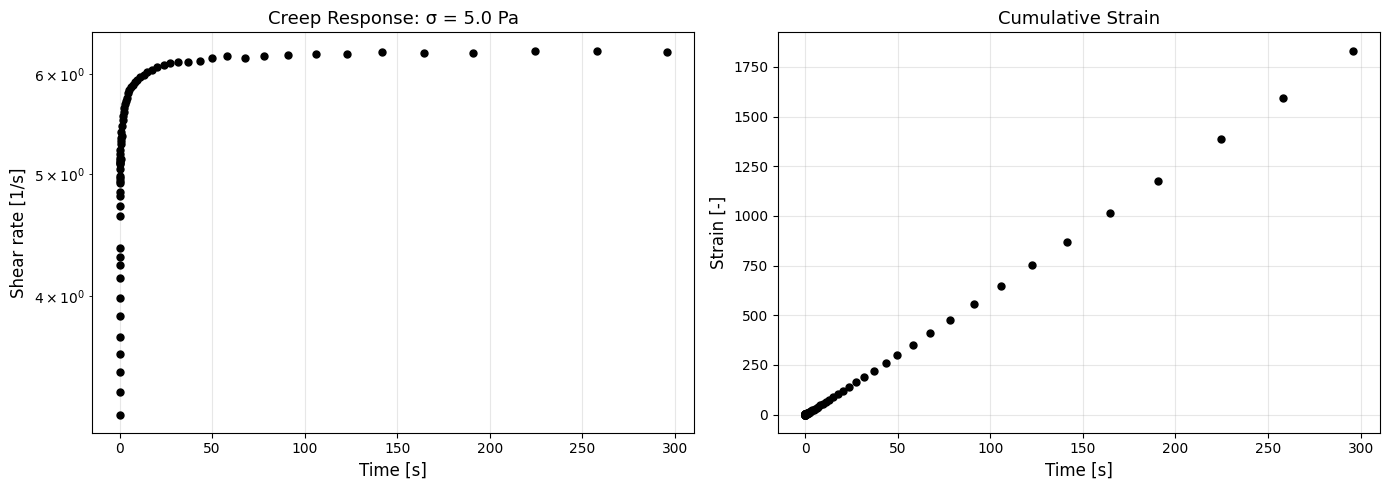

In [4]:
# Compute strain from shear rate (cumulative integration)
strain_data = np.cumsum(gamma_dot_data[:-1] * np.diff(time_data))
strain_data = np.insert(strain_data, 0, 0.0)

# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.semilogy(time_data, gamma_dot_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Shear rate [1/s]", fontsize=12)
ax1.set_title(f"Creep Response: σ = {sigma_final} Pa", fontsize=13)
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, strain_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain [-]", fontsize=12)
ax2.set_title("Cumulative Strain", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, strain_data, test_mode="creep", sigma_applied=sigma_final, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

NLSQ fit time: 42.09 s

Fitted parameters:
  G               = 1000
  eta             = 0.8115
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  alpha_structure = 0.7
  eta_inf         = 0.1
  mu_p            = 0.001



Fit Quality:
  R^2:   0.999908
  RMSE:  3.745


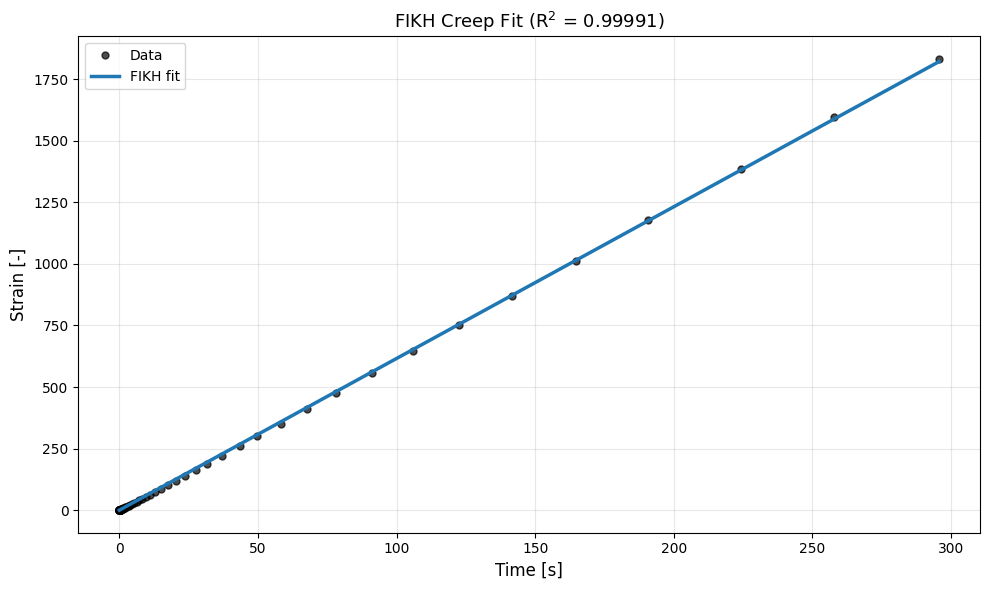

In [6]:
# Compute fit quality and plot
strain_pred = model.predict(time_data, test_mode="creep", sigma_applied=sigma_final)
metrics = compute_fit_quality(strain_data, strain_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g}")

time_fine = np.linspace(time_data.min(), time_data.max(), 300)
strain_pred_fine = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_final)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, strain_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.plot(time_fine, strain_pred_fine, "-", lw=2.5, color="C0", label="FIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Strain [-]", fontsize=12)
ax.set_title(f"FIKH Creep Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Exploration

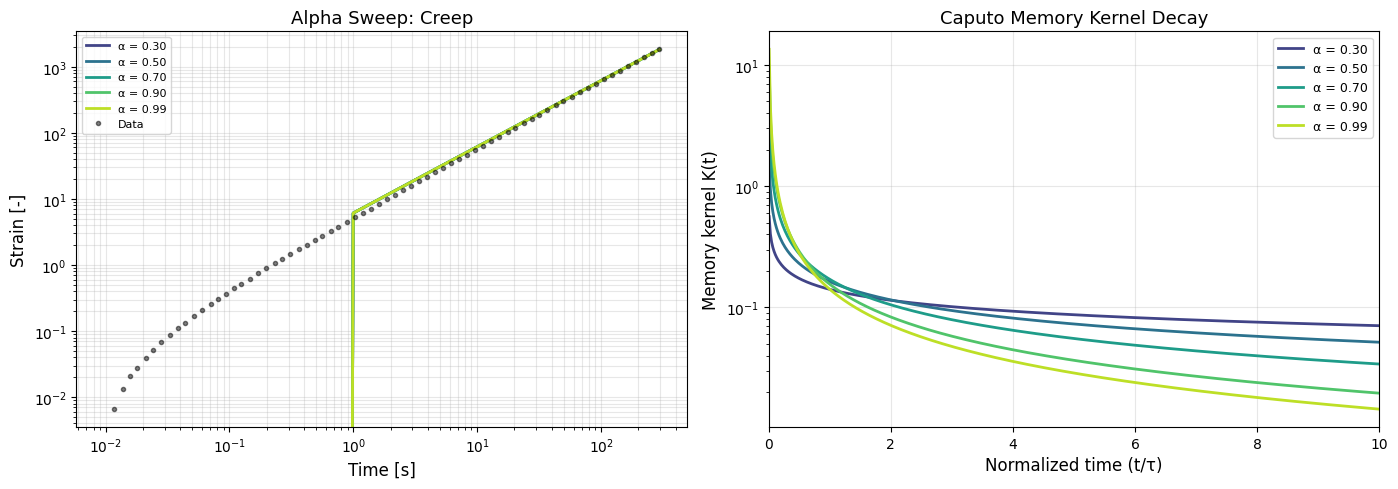

In [7]:
# Alpha sweep for creep
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="creep",
    alpha_values=alpha_values,
    x_data=time_fine,
    sigma_applied=sigma_final,
    figsize=(14, 5),
)

fig.axes[0].plot(time_data, strain_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

In [8]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.700

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


## 6. Bayesian Inference

In [9]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    strain_data,
    test_mode="creep",
    sigma_applied=sigma_final,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


/Users/b80985/Projects/rheojax/rheojax/core/base.py:457: RuntimeWarning: Warm-started NUTS initialization failed; retrying with uniform init.
  result = super().fit_bayesian(


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:04<53:14,  4.57s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▎         | 25/700 [00:04<01:30,  7.49it/s, 3 steps of size 2.22e-04. acc. prob=0.84]

warmup:   7%|▋         | 52/700 [00:04<00:37, 17.48it/s, 447 steps of size 3.05e-03. acc. prob=0.92]

warmup:   9%|▉         | 66/700 [00:07<01:08,  9.24it/s, 511 steps of size 7.89e-03. acc. prob=0.94]

warmup:  11%|█         | 75/700 [00:09<01:18,  7.99it/s, 511 steps of size 1.31e-02. acc. prob=0.95]

warmup:  12%|█▏        | 81/700 [00:10<01:16,  8.07it/s, 255 steps of size 1.78e-02. acc. prob=0.95]

warmup:  12%|█▏        | 85/700 [00:10<01:14,  8.24it/s, 255 steps of size 2.13e-02. acc. prob=0.95]

warmup:  13%|█▎        | 88/700 [00:11<01:10,  8.70it/s, 255 steps of size 2.34e-02. acc. prob=0.95]

warmup:  13%|█▎        | 91/700 [00:11<01:06,  9.14it/s, 255 steps of size 2.67e-02. acc. prob=0.96]

warmup:  13%|█▎        | 94/700 [00:11<01:06,  9.07it/s, 255 steps of size 2.97e-02. acc. prob=0.96]

warmup:  14%|█▎        | 96/700 [00:11<01:04,  9.34it/s, 255 steps of size 3.13e-02. acc. prob=0.96]

warmup:  14%|█▍        | 98/700 [00:11<00:59, 10.14it/s, 127 steps of size 3.36e-02. acc. prob=0.96]

warmup:  14%|█▍        | 100/700 [00:11<00:53, 11.20it/s, 255 steps of size 3.52e-02. acc. prob=0.96]

warmup:  16%|█▌        | 110/700 [00:12<00:25, 23.26it/s, 31 steps of size 2.74e-01. acc. prob=0.96] 

warmup:  18%|█▊        | 124/700 [00:12<00:13, 42.13it/s, 31 steps of size 2.39e-01. acc. prob=0.96]

warmup:  20%|█▉        | 138/700 [00:12<00:09, 60.15it/s, 31 steps of size 2.27e-01. acc. prob=0.97]

warmup:  21%|██        | 147/700 [00:12<00:08, 65.00it/s, 31 steps of size 2.23e-01. acc. prob=0.97]

warmup:  22%|██▏       | 157/700 [00:12<00:07, 72.58it/s, 31 steps of size 1.04e-01. acc. prob=0.96]

warmup:  24%|██▎       | 166/700 [00:12<00:08, 66.10it/s, 31 steps of size 1.21e-01. acc. prob=0.96]

warmup:  25%|██▍       | 174/700 [00:12<00:08, 64.68it/s, 31 steps of size 1.54e-01. acc. prob=0.97]

warmup:  26%|██▌       | 182/700 [00:12<00:07, 67.27it/s, 31 steps of size 1.85e-01. acc. prob=0.97]

warmup:  27%|██▋       | 190/700 [00:13<00:07, 70.04it/s, 31 steps of size 1.96e-01. acc. prob=0.97]

sample:  29%|██▊       | 201/700 [00:13<00:06, 77.95it/s, 31 steps of size 1.89e-01. acc. prob=0.98]

sample:  30%|███       | 211/700 [00:13<00:06, 80.67it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [00:13<00:06, 78.60it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [00:13<00:05, 81.17it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [00:13<00:05, 87.60it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [00:13<00:04, 93.10it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [00:13<00:04, 96.74it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [00:13<00:04, 91.78it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  40%|████      | 283/700 [00:14<00:04, 90.79it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  42%|████▏     | 293/700 [00:14<00:04, 89.31it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  43%|████▎     | 302/700 [00:14<00:04, 84.87it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  45%|████▍     | 312/700 [00:14<00:04, 87.07it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [00:14<00:04, 89.90it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [00:14<00:04, 90.89it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [00:14<00:04, 85.48it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  50%|█████     | 352/700 [00:14<00:03, 88.98it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  52%|█████▏    | 362/700 [00:14<00:03, 89.96it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  53%|█████▎    | 372/700 [00:15<00:03, 92.43it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [00:15<00:03, 90.66it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [00:15<00:03, 96.67it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  58%|█████▊    | 404/700 [00:15<00:03, 76.76it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [00:15<00:03, 72.33it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  61%|██████    | 424/700 [00:15<00:03, 79.53it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [00:15<00:03, 79.67it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [00:15<00:03, 82.14it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:16<00:03, 82.20it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [00:16<00:02, 88.94it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [00:16<00:02, 90.59it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [00:16<00:02, 91.46it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  70%|███████   | 492/700 [00:16<00:02, 88.22it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [00:16<00:02, 89.63it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [00:16<00:02, 82.93it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:16<00:02, 86.20it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [00:16<00:01, 87.57it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [00:17<00:01, 87.16it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [00:17<00:01, 90.26it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  80%|████████  | 561/700 [00:17<00:01, 90.42it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [00:17<00:01, 84.25it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [00:17<00:01, 73.94it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [00:17<00:01, 77.45it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [00:17<00:01, 78.94it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [00:17<00:01, 85.15it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [00:17<00:00, 98.44it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [00:18<00:00, 101.40it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [00:18<00:00, 96.20it/s, 31 steps of size 1.89e-01. acc. prob=0.99] 

sample:  94%|█████████▎| 656/700 [00:18<00:00, 92.78it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [00:18<00:00, 79.30it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [00:18<00:00, 69.08it/s, 15 steps of size 1.89e-01. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [00:18<00:00, 77.73it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:18<00:00, 84.32it/s, 31 steps of size 1.89e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:18<00:00, 36.96it/s, 31 steps of size 1.89e-01. acc. prob=0.99]


Bayesian inference time: 34.2 s


In [10]:
# Convergence
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


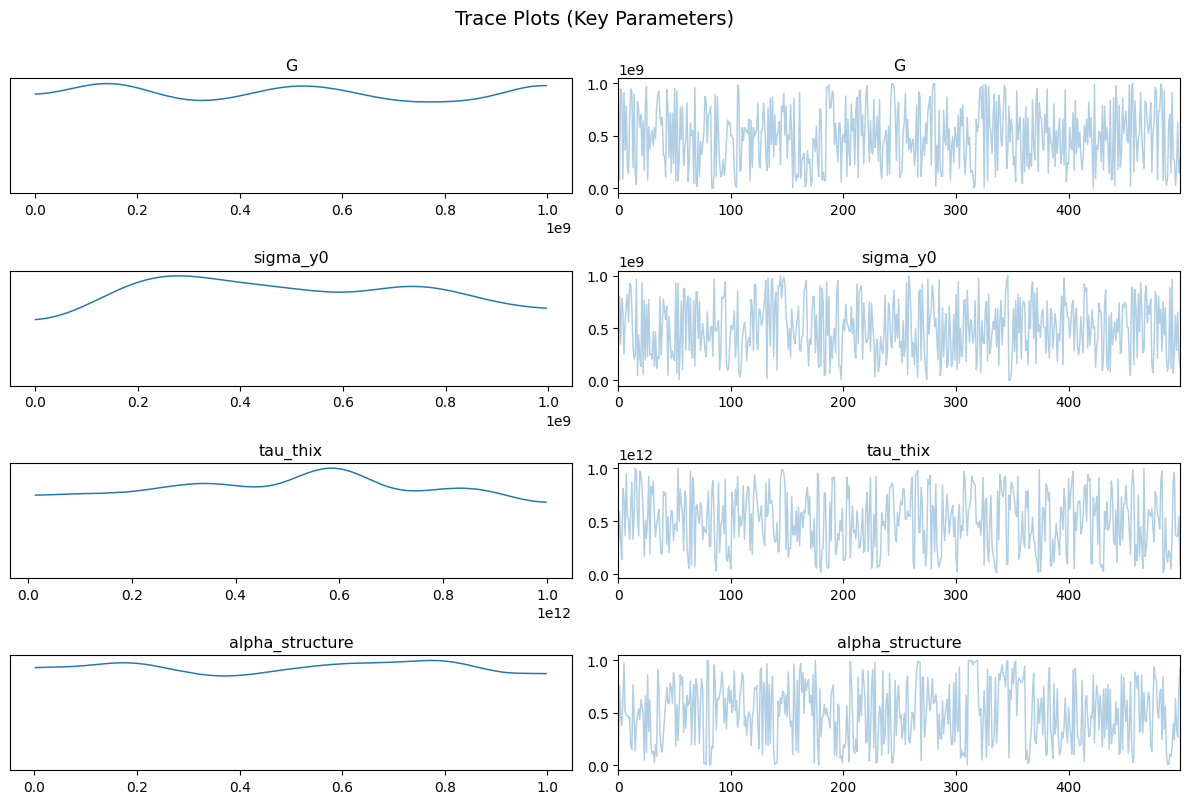

In [11]:
# Trace plots
idata = result.to_inference_data()
key_params = ["G", "sigma_y0", "tau_thix", "alpha_structure"]
axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

In [12]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000     4.968e+08  [2.346e+07, 9.785e+08]
            eta        0.8115     4.782e+11  [4.232e+10, 9.387e+11]
              C           500     4.677e+08  [1.016e+07, 9.784e+08]
      gamma_dyn             1          5198  [240.7, 9825]
              m             1         1.747  [0.5854, 2.942]
       sigma_y0            10     4.936e+08  [5.049e+07, 9.593e+08]
  delta_sigma_y            50     5.085e+08  [2.939e+07, 9.772e+08]
       tau_thix             1     5.341e+11  [5.141e+10, 9.666e+11]
          Gamma           0.5          5285  [405.7, 9783]
alpha_structure           0.7        0.5099  [0.01933, 0.9903]
        eta_inf           0.1     5.066e+08  [3.245e+07, 9.786e+08]
           mu_p         0.001         524.5  [28.01, 971.1]


## 7. Save Results

In [13]:
save_fikh_results(model, result, "fikh", "creep", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/creep/
  nlsq_params_creep.json: 12 parameters
  posterior_creep.json: 500 draws

Results saved.


## Key Takeaways

1. **Creep reveals delayed yielding** with viscosity bifurcation
2. **Lower alpha** → stretched creep acceleration, slower yielding
3. **Higher alpha** → sharper yield transition (classical)
4. **Creep data constrains yield parameters** (sigma_y0, delta_sigma_y)
5. **Combined protocols** (flow curve + creep) improve alpha estimation

### Next Steps

- **NB05**: SAOS (frequency response)
- **NB06**: LAOS (nonlinear oscillatory)